In [ ]:
# Deconvolves 2D psfs, to remove effect of collimator

In [1]:
import numpy as np
from scipy import signal
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import fftpack

%matplotlib qt

In [ ]:
'''
Email from RZ, 2024 04 12:

Attached please find the spot diagram of your projector we assembled yesterday. The diamond turned off-axis parabola has astigmatism 
which was seen going in and out of focus and the resulting image has significant aberrations. FWHM is 6 pixels (5.2 micron each). 
This is certainly much over the diffraction limit which we would expected for a test beam which should be perfect to measure aberrations 
of the camera.

The camera image quality may be evaluated with the projector if the measured and magnified spot size of the projector input is 
de-convolved from the camera image. I obtained much smaller spot through the camera with the PSF mask at the camera focus.

The projector can be used for all other tests, in particular, field of view, repeatability etc. because we don’t care about PSF size 
and measure centroid on the detector only.

Slack message from RZ later:

'Eckhart and I tested the spot projector and discovered that it produces the image 6 pixels FWHM (5.2 micron pixels). The camera will 
magnify the spot projector input by the factor of 2. This resulting value has to be deconvolved from the images on the detector to yield 
the camera PSF. This is an important moment: what you see on the detector is not yet PSF. PSF is the result of frame processing.'
'''

In [2]:
def gaussian(x,x0,sigma):
  return np.exp(-np.power((x - x0)/sigma, 2.)/2.)

In [3]:
# fake signal
abcissa_true_signal = np.linspace(0,100,101)
# Create a Gaussian distribution based on abcissa_true_signal
ordinate_true_signal = gaussian(abcissa_true_signal, x0=50, sigma=2)

# impulse response
ordinate_impulse_response = gaussian(abcissa_true_signal, x0=50, sigma=10)

# convolve
ordinate_recorded_signal = signal.convolve(ordinate_impulse_response, ordinate_true_signal)

# deconvolve
ordinate_recovered, remainder = signal.deconvolve(ordinate_recorded_signal, ordinate_impulse_response)

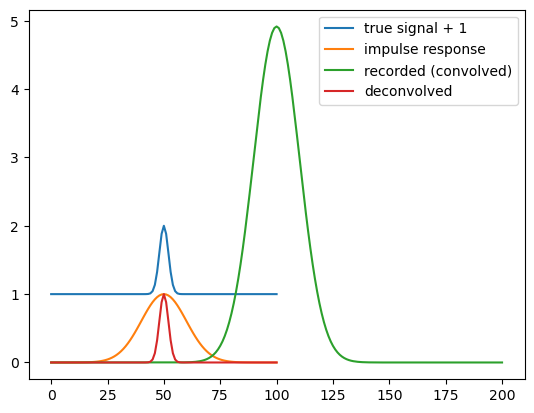

In [8]:
plt.plot(abcissa_true_signal, ordinate_true_signal+1, label='true signal + 1')
plt.plot(abcissa_true_signal, ordinate_impulse_response, label='impulse response')
plt.plot(ordinate_recorded_signal, label='recorded (convolved)')
plt.plot(abcissa_true_signal, ordinate_recovered, label='deconvolved')
plt.legend()
plt.show()

In [4]:
# ex.

original = [0, 1, 0, 0, 1, 1, 0, 0]
impulse_response = [2, 1]

print(original)

recorded = signal.convolve(impulse_response, original)
print(recorded)


recovered, remainder = signal.deconvolve(recorded, impulse_response)
print(recovered)
print(remainder)

[0, 1, 0, 0, 1, 1, 0, 0]
[0 2 1 0 2 3 1 0 0]
[0. 1. 0. 0. 1. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [5]:
import numpy as np
# 2D

# true object: checkerboard
checker = np.zeros((100, 100))

subarray_size = 10

for i in range(0, checker.shape[0], 2*subarray_size):
    for j in range(0, checker.shape[1], 2*subarray_size):
        checker[i:i+subarray_size, j:j+subarray_size] = 1

# impulse response: 2D Gaussian
x, y = np.meshgrid(np.arange(100), np.arange(100))
center_x = 50
center_y = 50
width = 1
gaussian_array = np.exp(-((x - center_x)**2 + (y - center_y)**2) / (2 * width**2))

# 2D convolve the two
convolve_2d = signal.convolve2d(checker, gaussian_array, boundary='symm', mode='same')

plt.imshow(checker)
plt.colorbar()
plt.show()

plt.imshow(gaussian_array)
plt.show()

plt.imshow(convolve_2d)
plt.show()


In [ ]:
# Deconvolve in 2D:

# a * b = c
# a: truth 
# *: convolution
# b: impulse response
# c: recorded

# Naive (no regularizer):
# In Fourier space, 
# FT[ a * b ] = FT[ c ]
# Then,
# a = IFT[ FT[ b ] / FT [ c ] ]

In [9]:
print()

[[ 0.119024   -0.67572314 -1.17477306 ...  0.30930435  1.992163
  -1.35348857]
 [ 0.48532451 -0.48806176 -0.08145656 ... -0.21227682 -0.17904593
   0.96070201]
 [ 0.84598588 -1.35096997  0.68114435 ... -0.23740699  1.53045134
  -0.04775146]
 ...
 [-0.24982405 -0.50629887  0.06178142 ...  0.2874358   1.24832432
   1.08830975]
 [-0.46899867  0.49232005 -1.39497166 ... -0.49352333 -0.68088555
   0.14669628]
 [ 0.14772098  1.96200547 -0.44433399 ...  0.35919043 -1.58685831
   1.24224828]]


In [13]:
# example code from 
# https://stackoverflow.com/questions/17473917/is-there-a-equivalent-of-scipy-signal-deconvolve-for-2d-arrays

def convolve(star, psf):
    star_fft = fftpack.fftshift(fftpack.fftn(star))
    psf_fft = fftpack.fftshift(fftpack.fftn(psf))
    return fftpack.fftshift(fftpack.ifftn(fftpack.ifftshift(star_fft*psf_fft)))

def deconvolve(star, psf):
    star_fft = fftpack.fftshift(fftpack.fftn(star))
    psf_fft = fftpack.fftshift(fftpack.fftn(psf))
    return fftpack.fftshift(fftpack.ifftn(fftpack.ifftshift(star_fft/psf_fft)))

star = checker
psf = gaussian_array

# add noise
'''
star += np.random.normal(scale = 0.1, size = np.shape(star))
psf += np.random.normal(scale = 0.1, size = np.shape(star))
'''

star_conv = convolve(star, psf)
star_deconv = deconvolve(star_conv, psf) # noiseless

f, axes = plt.subplots(2,2)
axes[0,0].imshow(star)
axes[0,1].imshow(psf)
axes[1,0].imshow(np.real(star_conv))
axes[1,1].imshow(np.real(star_deconv))
plt.show()

TypeError: Image data of dtype complex128 cannot be converted to float